# Model10: GMM

## A. Functions

There have four different functions.

* Data reader: Read data from file.
* Feature functions(private): Functions which extract features are placed in here. It means that if you make a specific feature function, you can add the one into here.
* Feature function(public): We can use only this function for feature extraction.
* Utility functions: All the funtions except functions which are mentioned in above should be placed in here.

### Data reader

In [215]:
import gzip
import pickle
from os import path
from collections import defaultdict
from numpy import sign


"""
Load buzz data as a dictionary.
You can give parameter for data so that you will get what you need only.
"""
def load_buzz(root='../data', data=['train', 'test', 'questions'], format='pklz'):
    buzz_data = {}
    for ii in data:
        file_path = path.join(root, ii + "." + format)
        with gzip.open(file_path, "rb") as fp:
          buzz_data[ii] = pickle.load(fp)
        
    return buzz_data

### Feature functions(private)

In [216]:
from numpy import sign, abs


def _feat_basic(bd, group):
    X = []
    for item in bd[group].items():
        qid = item[1]['qid']
        q = bd['questions'][qid]
        #item[1]['q_length'] = max(q['pos_token'].keys())
        item[1]['q_length'] = len(q['question'].split())
        item[1]['category'] = q['category'].lower()
        item[1]['answer'] = q['answer'].lower()
        X.append(item[1])
        
    return X
        
        
def _feat_sign_val(data):
    for item in data:
        item['sign_val'] = sign(item['position'])

def _get_pos(bd, sign_val=None):
    # bd is not bd, bd is bd['train']
    unwanted_index = []
    pos_uid = defaultdict(list)
    pos_qid = defaultdict(list)
    
    for index, key in enumerate(bd):
        if sign_val and sign(bd[key]['position']) != sign_val:
            unwanted_index.append(index)
        else:
            pos_uid[bd[key]['uid']].append(bd[key]['position'])
            pos_qid[bd[key]['qid']].append(bd[key]['position'])
    
    return pos_uid, pos_qid, unwanted_index


def _get_avg_pos(bd, sign_val=None):
    pos_uid, pos_qid, unwanted_index = _get_pos(bd, sign_val)

    avg_pos_uid = {}
    avg_pos_qid = {}
    
    if not sign_val:
        sign_val = 1

    for key in pos_uid:
        pos = pos_uid[key]
        avg_pos_uid[key] = sign_val * (sum(pos) / len(pos))

    for key in pos_qid:
        pos = pos_qid[key]
        avg_pos_qid[key] = sign_val * (sum(pos) / len(pos))
    
    return avg_pos_uid, avg_pos_qid, unwanted_index

        
def _feat_avg_pos(data, bd, group, sign_val):
    avg_pos_uid, avg_pos_qid, unwanted_index = _get_avg_pos(bd['train'], sign_val=sign_val)
    
    if group == 'train':
        for index in sorted(unwanted_index, reverse=True):
            del data[index]
    
    for item in data:
        if item['uid'] in avg_pos_uid:
            item['avg_pos_uid'] = avg_pos_uid[item['uid']]
        else:
            vals = avg_pos_uid.values()
            item['avg_pos_uid'] = sum(vals) / float(len(vals))
              
        if item['qid'] in avg_pos_qid:
            item['avg_pos_qid'] = avg_pos_qid[item['qid']]
        else:
            vals = avg_pos_qid.values()
            item['avg_pos_qid'] = sum(vals) / float(len(vals))
        
        # Response position can be longer than length of question
        if item['avg_pos_uid'] > item['q_length']:
            item['avg_pos_uid'] = item['q_length']
        
        if item['avg_pos_qid'] > item['q_length']:
            item['avg_pos_qid'] = item['q_length']

### Feature function(public)

In [217]:
def featurize(bd, group, sign_val=None, extra=None):
    # Basic features
    # qid(string), uid(string), position(float)
    # answer'(string), 'potistion'(float), 'qid'(string), 'uid'(string)
    X = _feat_basic(bd, group=group)
    
    # Some extra features
    if extra:
        for func_name in extra:
            func_name = '_feat_' + func_name
            if func_name in ['_feat_avg_pos']:
                globals()[func_name](X, bd, group=group, sign_val=sign_val)
            else:
                globals()[func_name](X)
    
    if group == 'train':
        y = []
        for item in X:
            y.append(item['position'])
            del item['position']

        return X, y
    elif group == 'test':
        return X
    else:
        raise ValueError(group, 'is not the proper type')

### Utility functions

In [218]:
import csv


def select(data, keys):
    unwanted = data[0].keys() - keys
    for item in data:
        for unwanted_key in unwanted:
            del item[unwanted_key]
    return data


def write_result(test_set, predictions, file_name='guess.csv'):
    predictions = sorted([[id, predictions[index]] for index, id in enumerate(test_set.keys())])
    predictions.insert(0,["id", "position"])
    with open(file_name, "w") as fp:
        writer = csv.writer(fp, delimiter=',')
        writer.writerows(predictions)

## GMM

### Classifying questions
features: avg_pos, accuracy rate

In [219]:
%matplotlib inline
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture


def plot_gmm(X, models, n_components, covariance_type='diag',
            figsize=(10, 20), suptitle=None, xlabel=None, ylabel=None):
    color_iter = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'pink', 'lime']
    plt.figure(figsize=figsize)
    plt.suptitle(suptitle, fontsize=20)

    for i, model in enumerate(models):
        mm = getattr(mixture, model)(n_components=n_components,
                                     covariance_type=covariance_type)
        mm.fit(X_pos_qid)
        Y = mm.predict(X_pos_qid)

        plt.subplot(len(models), 1, 1 + i)
        for i, color in enumerate(color_iter):
            plt.scatter(X_pos_qid[Y == i, 0], X_pos_qid[Y == i, 1], .7, color=color)
        plt.title(model, fontsize=15)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid()

    plt.show()

In [220]:
from collections import UserDict
import numpy as np


class DictDict(UserDict):
    def __init__(self, bd):
        UserDict.__init__(self)
        self._set_bd(bd)
        
    def sub_keys(self):
        return self[list(self.keys())[0]].keys()
            
    def select(self, sub_keys):
        vals = []
        for key in self:
            vals.append([self[key][sub_key] for sub_key in sub_keys])
        return np.array(vals)
    
    def sub_append(self, sub_key, values):
        for index, key in enumerate(self):
            self[key][sub_key] = values[index]

    
class Users(DictDict):
    def _set_bd(self, bd):
        pos_uid, _, _ = _get_pos(bd['train'], sign_val=None)
        for key in pos_uid:
            u = np.array(pos_uid[key])
            ave_pos_uid = sum(abs(u)) / float(len(u))
            acc_ratio_uid = len(u[u > 0]) / float(len(u))
            self[key] = {'ave_pos_uid': ave_pos_uid,
                         'acc_ratio_uid': acc_ratio_uid}

            
class Questions(DictDict):
    def _set_bd(self, bd):
        _, pos_qid, _ = _get_pos(bd['train'], sign_val=None)
        
        for key in pos_qid:
            u = np.array(pos_qid[key])
            ave_pos_qid = sum(abs(u)) / float(len(u))
            acc_ratio_qid = len(u[u > 0]) / float(len(u))
            self[key] = bd['questions'][key]
            self[key]['ave_pos_qid'] = ave_pos_qid
            self[key]['acc_ratio_qid'] = acc_ratio_qid

In [221]:
users = Users(load_buzz())
questions = Questions(load_buzz())
X_pos_uid = users.select(['ave_pos_uid', 'acc_ratio_uid'])
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid'])

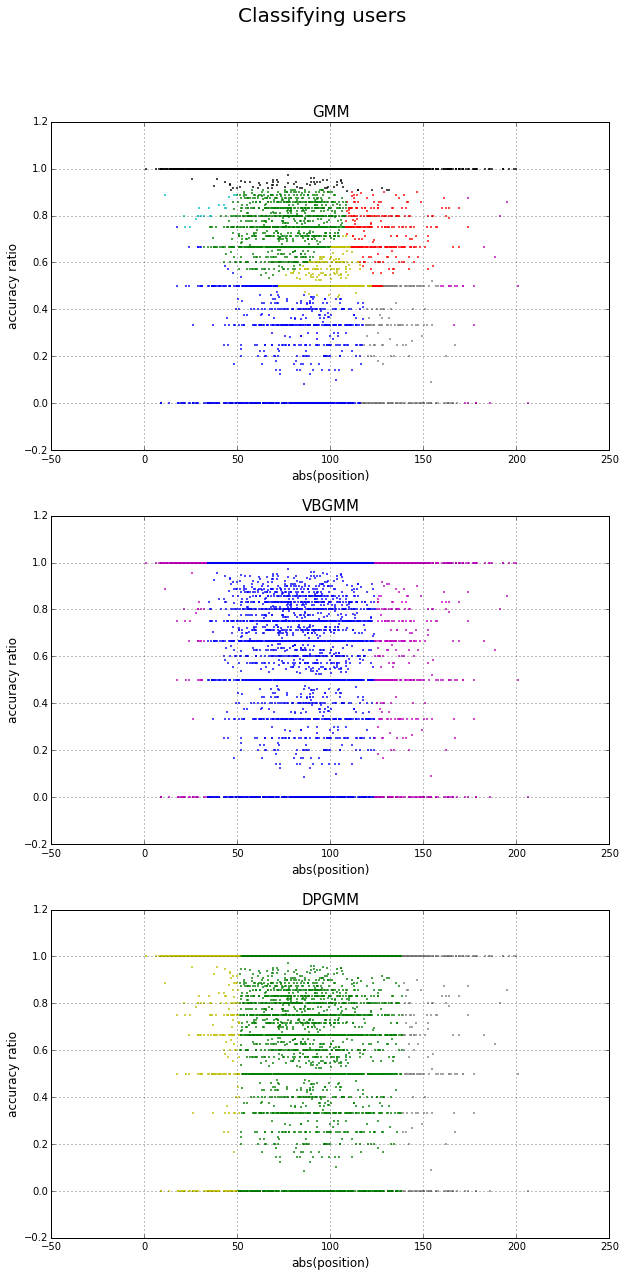

In [222]:
plot_gmm(X_pos_uid,
         models=['GMM', 'VBGMM', 'DPGMM'],
         n_components=8,
         covariance_type='diag',
         figsize=(10, 20),
         suptitle='Classifying users',
         xlabel='abs(position)',
         ylabel='accuracy ratio')

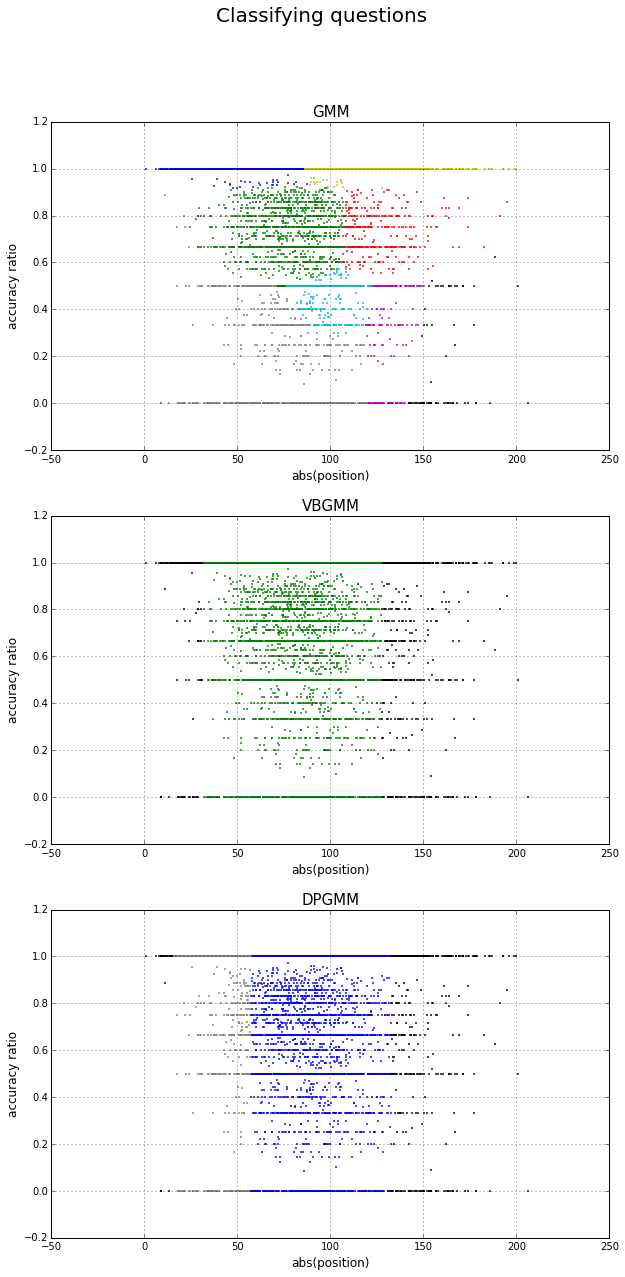

In [223]:
plot_gmm(X_pos_qid,
         models=['GMM', 'VBGMM', 'DPGMM'],
         n_components=8,
         covariance_type='diag',
         figsize=(10, 20),
         suptitle='Classifying questions',
         xlabel='abs(position)',
         ylabel='accuracy ratio')

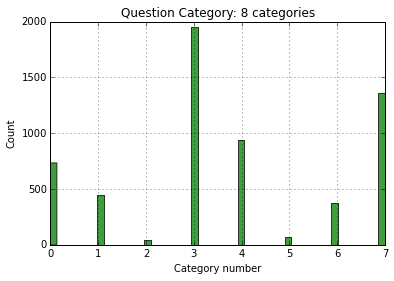

In [224]:
# Question category
n_components = 8
gmm = mixture.GMM(n_components=n_components, covariance_type='diag')
gmm.fit(X_pos_qid)
pred_cat_qid = gmm.predict(X_pos_qid)

plt.hist(pred_cat_qid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("Question Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

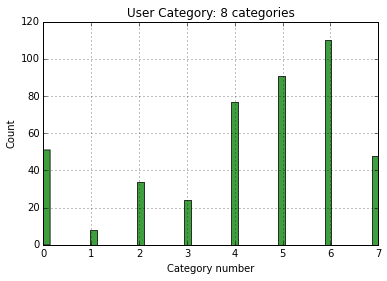

In [225]:
# User category
n_components = 8
gmm = mixture.GMM(n_components=n_components, covariance_type='diag')
gmm.fit(X_pos_uid)
pred_cat_uid = gmm.predict(X_pos_uid)

plt.hist(pred_cat_uid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("User Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

In [226]:
users.sub_append('cat', [str(x) for x in pred_cat_uid])

In [227]:
questions.sub_append('cat', [str(x) for x in pred_cat_qid])

In [228]:
print(users[1])
print(questions[1])

{'ave_pos_uid': 96.724899598393577, 'acc_ratio_uid': 0.6465863453815262, 'cat': '6'}
{'question': "This painter's indulgence of visual fantasy, and appreciation of different historic architectural styles can be seen in his 1840 Architect's Dream. After a series of paintings on The Last of the Mohicans, he made a three year trip to Europe in 1829, but he is better known for a trip four years earlier in which he journeyed up the Hudson River to the Catskill Mountains. FTP, name this painter of The Oxbow and The Voyage of Life series.", 'group': 'test', 'acc_ratio_qid': 0.875, 'category': 'Fine Arts', 'cat': '7', 'pos_token': {0: '', 1: 'painters', 2: 'indulgence', 4: 'visual', 5: 'fantasy', 68: 'this_painter', 7: 'appreciation', 64: 'mountains', 9: 'different', 10: 'historic', 11: 'architectural', 12: 'styles', 66: 'name', 77: 'series', 15: 'seen', 18: '1840', 19: 'architects', 20: 'dream', 23: 'series', 25: 'paintings', 28: 'last', 31: 'mohicans', 33: 'made', 35: 'three', 36: 'year', 37

## B. Modeling

### Select model

In [229]:
regression_keys = ['category', 'q_length', 'qid', 'uid', 'answer', 'avg_pos_uid', 'avg_pos_qid']
X_train, y_train = featurize(load_buzz(), group='train', sign_val=None, extra=['sign_val', 'avg_pos'])
X_train = select(X_train, regression_keys)

In [230]:
for index, item in enumerate(X_train):
    uid = item['uid']
    qid = item['qid']
    item['acc_ratio_uid'] = users[uid]['acc_ratio_uid']
    item['acc_ratio_qid'] = questions[qid]['acc_ratio_qid']
    item['uid'] = str(uid)
    item['qid'] = str(qid)

In [231]:
X_train[1]

{'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'category': 'fine arts',
 'q_length': 78,
 'qid': '1',
 'uid': '1'}

In [232]:
import multiprocessing
from sklearn import linear_model
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction import DictVectorizer
import math
from numpy import abs, sqrt

vec = DictVectorizer()
X_train = vec.fit_transform(X_train)

regressor_names = """
LinearRegression
Ridge
Lasso
ElasticNet
"""
print ("=== Linear Cross validation RMSE scores:")
for regressor in regressor_names.split():
    scores = cross_val_score(getattr(linear_model, regressor)(),
                             X_train, y_train,
                             cv=10,
                             scoring='mean_squared_error',
                             n_jobs=multiprocessing.cpu_count()-1
                            )
    print (regressor, sqrt(abs(scores)).mean())

=== Linear Cross validation RMSE scores:
LinearRegression 70.2810444416
Ridge 69.2717788374
Lasso 68.8369688857
ElasticNet 68.8369447905


### Training and testing model

In [233]:
def transform(X):
    for index, item in enumerate(X):
        uid = item['uid']
        qid = item['qid']
        item['uid'] = str(uid)
        item['qid'] = str(qid)

        # uid
        if uid in users:
            item['acc_ratio_uid'] = users[uid]['acc_ratio_uid']
        else:
            acc = users.select(['acc_ratio_uid'])
            item['acc_ratio_uid'] = sum(acc) / float(len(acc))

        # qid
        if qid in questions:
            item['acc_ratio_qid'] = questions[qid]['acc_ratio_qid']
        else:
            acc = questions.select(['acc_ratio_qid'])
            item['acc_ratio_qid'] = sum(acc) / float(len(acc))

In [234]:
regression_keys = ['category', 'q_length', 'qid', 'uid', 'answer', 'avg_pos_uid', 'avg_pos_qid']
X_train, y_train = featurize(load_buzz(), group='train', sign_val=None, extra=['avg_pos'])
X_train = select(X_train, regression_keys)
X_test = featurize(load_buzz(), group='test', sign_val=None, extra=['avg_pos'])
X_test = select(X_test, regression_keys)

transform(X_train)
transform(X_test)

In [235]:
X_train[1]

{'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'category': 'fine arts',
 'q_length': 78,
 'qid': '1',
 'uid': '1'}

In [236]:
X_test[1]

{'acc_ratio_qid': 0.6428571428571429,
 'acc_ratio_uid': 0.6712328767123288,
 'answer': 'david hilbert',
 'avg_pos_qid': 15.571428571428571,
 'avg_pos_uid': 36.31506849315068,
 'category': 'mathematics',
 'q_length': 105,
 'qid': '9967',
 'uid': '131'}

In [237]:
vec = DictVectorizer()
vec.fit(X_train + X_test)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [238]:
regressor = linear_model.LassoCV(n_jobs=3, normalize=True)
regressor.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=3, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [239]:
print(regressor.coef_)
print(regressor.alpha_)

[ 0.          1.38525443 -0.         ...,  0.         -0.          0.        ]
0.0106529121617


In [242]:
predictions = regressor.predict(X_test)

## Writing result

In [243]:
write_result(load_buzz()['test'], predictions)

This submissions scores 

* 85.33520: normalize=True
* 85.82289: normalize=False